<figure style="text-align: center;">
  <img src="_static/intro/title_page.png" style="display: block; margin: 0 auto; width: 100%;">
</figure>

### 3D Simulation

Michael J. Pyrcz, Professor, The University of Texas at Austin 

[Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)

Chapter of e-book "Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy". 

```{admonition} Cite this e-Book as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy* [e-book]. Zenodo. doi:10.5281/zenodo.15169133 [![DOI](https://zenodo.org/badge/838927017.svg)](https://doi.org/10.5281/zenodo.15169132)  
```

The workflows in this book and more are available here:

```{admonition} Cite the GeostatsPyDemos GitHub Repository as:
:class: remove-from-content-only

Pyrcz, M.J., 2024, *GeostatsPyDemos: GeostatsPy Python Package for Spatial Data Analytics and Geostatistics Demonstration Workflows Repository* (0.0.1) [Software]. Zenodo. doi:10.5281/zenodo.12667036. GitHub Repository: https://github.com/GeostatsGuy/GeostatsPyDemos [![DOI](https://zenodo.org/badge/777871341.svg)](https://doi.org/10.5281/zenodo.12667035)



```

By Michael J. Pyrcz <br />
&copy; Copyright 2024.

This chapter is a tutorial for / demonstration of **3D simulation** with GeostatsPy. This includes codes and a demonstration with,

1. defining the 3D variogram models

2. 3D sequential indicator simulation

3. 3D sequential Gaussian simulation

For the theory with links to my record lectures see the previous 2D modeling chapters,

* [variogram calculation](https://geostatsguy.github.io/GeostatsPyDemos_Book/GeostatsPy_variogram_calculation.html)

* [variogram modeling](https://geostatsguy.github.io/GeostatsPyDemos_Book/GeostatsPy_variogram_calculation_and_modeling.html)

* [sequential Gaussian simulation](https://geostatsguy.github.io/GeostatsPyDemos_Book/GeostatsPy_simulation.html)

* [sequential indicator simulation](https://geostatsguy.github.io/GeostatsPyDemos_Book/GeostatsPy_categorical_indicator_simulation.html)

In these chapters you will get all of the needed theory and demonstrations. 


#### Geostatistics in 3D

I have a confession: many of the GSLIB functions in the GeostatsPy Python package were ported or written from scratch by me, often late at night and into the early morning hours, just in time for the next day’s lecture.

Back in 2018, I desperately needed a usable, open-source geostatistics Python package to teach my courses. I found one, but on the first day of the semester, it broke due to an update in a dependent package. With no alternatives, I decided to build my own. My goal was simple,

* implement the minimum necessary tools to teach geostatistics in practice, not just in theory.

Because:

* you can’t teach geostatistics without algorithms

* students weren’t going to edit parameter files and run old FORTRAN GSLIB executables. (I tried that once—many students dropped the course in the first week!)

* my Excel demonstrations are great for theory and math, but they don’t support building full models.

So, in those early days, I made a key decision, everything would be in 2D only. Why?

* there is less urgency for streamlined, optimized codes.

* it made testing and debugging much easier.

* it was perfect for live demos and slides, easy to explain, visualize, and diagnose.

Fast forward to now... I’m lucky to have an amazing graduate student team—typically 12–15 students, mostly PhDs—and many of them want to build 3D geostatistical models. So, I couldn’t help myself. I went back and updated every function, search algorithms, kriging, distance metrics with geometric anisotropy, and more... and finally,

* sgsim_3D - a 3D implementation of sequential Gaussian simulation

* sisim_3D - a 3D implementation of sequential indicator simulation

In the spirit of package documentation, I have converted my testing workflow into this e-book chapter, but I must include a warning. This is the initial version of these 2 3D algorithms with minimal testing. I have tested,

* simple and ordinary kriging

* stationary mean or proportion realizations

* data conditioning

but I have not yet tested,

* locally variable mean / proportion

* collocated cokriging

For large 3D models, I still recommend the GSLIB wrappers in the GSLIB module of GeostatsPy,

* GSLIB.sgsim_3D - writes out a GSLIB .par file, executes the sgsim.exe and then reads the output back as a 3D ndarray.

* GSLIB.sisim_3D (TO BE ADDED SOON) - writes out a GSLIB .par file, executes the sisim.exe and then reads the output back as a 3D ndarray.

In my experience, the Python implementation of GeostatsPy cannot compete with the speed original FORTRAN GSLIB for large models!

I hope this is helpful, I welcome any bug reports or suggestions,

Michael

In [1]:
import geostatspy.GSLIB as GSLIB                              # we just need the plotting methods
import geostatspy.geostats as geostats                        # we just need the method for making variogram     
import geostatspy
print('GeostatsPy version: ' + str(geostatspy.__version__))  

GeostatsPy version: 0.0.71


We will also need some standard packages. These should have been installed with Anaconda 3.

In [2]:
import os                                                     # set working directory, run executables

from tqdm import tqdm                                         # suppress the status bar
from functools import partialmethod
tqdm.__init__ = partialmethod(tqdm.__init__, disable=True)

ignore_warnings = True                                        # ignore warnings?
import numpy as np                                            # ndarrays for gridded data
import pandas as pd                                           # DataFrames for tabular data
import matplotlib.pyplot as plt                               # for plotting
import matplotlib.gridspec as gridspec                        # flexible subplots
import matplotlib as mpl                                      # custom colorbar
from mpl_toolkits.mplot3d import Axes3D                       # 3D plotting
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator) # control of axes ticks
plt.rc('axes', axisbelow=True)                                # plot all grids below the plot elements
if ignore_warnings == True:                                   
    import warnings
    warnings.filterwarnings('ignore')
cmap = plt.cm.inferno                                         # color map

#### Make Custom Colorbar

We make this colorbar to display our categorical, sand and shale facies.

In [3]:
cmap_facies = mpl.colors.ListedColormap(['grey','gold'])
cmap_facies.set_over('white'); cmap_facies.set_under('white')

#### Declare Functions

Here's some convience functions to support this demonstration workflow,

* adding gridlines to our plots

* making a 3D grid parameter dictionary

* making a set of center slice plots with annotation for our 3D models

In [4]:
def add_grid():
    plt.gca().grid(True, which='major',linewidth = 1.0); plt.gca().grid(True, which='minor',linewidth = 0.2) # add y grids
    plt.gca().tick_params(which='major',length=7); plt.gca().tick_params(which='minor', length=4)
    plt.gca().xaxis.set_minor_locator(AutoMinorLocator()); plt.gca().yaxis.set_minor_locator(AutoMinorLocator()) # turn on minor ticks

def make_grid_3D(xmin, xmax, nx,ymin, ymax, ny,zmin, zmax, nz):
    """
    Create a 3D grid dictionary with GEODAS-style parameters and computed extents.

    Args:
        xmin, xmax, nx: Grid min, max and number of cells in X
        ymin, ymax, ny: Grid min, max and number of cells in Y
        zmin, zmax, nz: Grid min, max and number of cells in Z

    Returns:
        dict containing:
            - xsiz, ysiz, zsiz
            - nx, ny, nz
            - xmn, ymn, zmn (center of first cell)
            - xmin, xmax, ymin, ymax, zmin, zmax (computed extents)
    """
    assert xmax > xmin and nx > 0, "Invalid x-dimension parameters" # validate input
    assert ymax > ymin and ny > 0, "Invalid y-dimension parameters"
    assert zmax > zmin and nz > 0, "Invalid z-dimension parameters"

    xsiz = (xmax - xmin) / nx                                 # compute cell sizes
    ysiz = (ymax - ymin) / ny
    zsiz = (zmax - zmin) / nz

    xmn = xmin + xsiz * 0.5                                   # compute centers of first cells (GEODAS-style)
    ymn = ymin + ysiz * 0.5
    zmn = zmin + zsiz * 0.5

    xmin_calc = xmn - xsiz * 0.5                              # recalculate extents from cell-center origin for consistency
    xmax_calc = xmin_calc + nx * xsiz

    ymin_calc = ymn - ysiz * 0.5
    ymax_calc = ymin_calc + ny * ysiz

    zmin_calc = zmn - zsiz * 0.5
    zmax_calc = zmin_calc + nz * zsiz

    return {
        'xsiz': xsiz, 'ysiz': ysiz, 'zsiz': zsiz,             # cell sizes
        'nx': nx, 'ny': ny, 'nz': nz,                         # cell counts
        'xmn': xmn, 'ymn': ymn, 'zmn': zmn,                   # origins (center of first cell)
        'xmin': xmin_calc, 'xmax': xmax_calc,                 # calculated extents
        'ymin': ymin_calc, 'ymax': ymax_calc,
        'zmin': zmin_calc, 'zmax': zmax_calc
    }

def plot_center_slices_3D(array,grd3D,title,feature,vmin,vmax,nvbin,cmap):
    icx = int(grd3D['nx']/2); cx = grd3D['xmn'] + icx*grd3D['xsiz'] # center layers and slices for plotting
    icy = int(grd3D['ny']/2); cy = grd3D['ymax'] - (grd3D['ymn'] + icy*grd3D['ysiz'])
    icz = int(grd3D['nz']/2); cz = grd3D['zmn'] + icz*grd3D['zsiz']                    
    
    gs = gridspec.GridSpec(2, 2, width_ratios=[2, 1])         # wider column on the left
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_subplot(gs[:, 0])                           # left column, spans both rows
    ax2 = fig.add_subplot(gs[0, 1])                           # top right
    ax3 = fig.add_subplot(gs[1, 1])                           # bottom right
    
    im1 = ax1.imshow(array[icz],interpolation = None,extent = [grd3D['xmin'],grd3D['xmax'],grd3D['ymin'],grd3D['ymax']], 
        vmin = vmin, vmax = vmax,cmap = cmap)
    ax1.set_title(title + ' - iz = ' + str(icz)); ax1.set_xlabel('X (m)'); ax1.set_ylabel('Y (m)')
    ax1.plot([grd3D['xmin'],grd3D['xmax']],[cy,cy],color='white'); ax1.plot([cx,cx],[grd3D['ymin'],grd3D['ymax']],color='white')
    ax1.annotate('ix = ' + str(icx),[cx,grd3D['ymin']+ 0.91*(grd3D['ymin']+grd3D['ymax'])], rotation= 90.0)
    ax1.annotate('iy = ' + str(icy),[grd3D['xmin']+ 0.02*(grd3D['xmin']+grd3D['xmax']),cy])
    cbar = plt.colorbar(im1, orientation="vertical", ticks=np.linspace(vmin,vmax,nvbin)); cbar.set_label(feature, rotation=270, labelpad=20)
    
    im2 = ax2.imshow(np.flip(array[:,:,icx],axis=1),interpolation = None,extent = [grd3D['xmin'],grd3D['xmax'],grd3D['zmin'],grd3D['zmax']], 
        vmin = vmin, vmax = vmax,cmap = cmap,aspect = 30.0)
    ax2.set_title(title + ' - ix = ' + str(icx)); ax2.set_yticks([grd3D['zmin'],grd3D['zmax']])
    ax2.plot([grd3D['xmin'],grd3D['xmax']],[cz,cz],color='white'); ax2.plot([cx,cx],[grd3D['zmin'],grd3D['zmax']],color='white')
    ax2.annotate('iz = ' + str(icz),[grd3D['xmin']+ 0.02*(grd3D['xmin']+grd3D['xmax']),cz])
    ax2.annotate('iy = ' + str(icy),[cy,grd3D['ymin']+ 0.1*(grd3D['zmin']+grd3D['zmax'])], rotation= 90.0)
    ax2.set_xlabel('Y (m)'); ax2.set_ylabel('Z (m)')
    
    im3 = ax3.imshow(array[:,icy,:],interpolation = None,extent = [grd3D['ymin'],grd3D['ymax'],grd3D['zmin'],grd3D['zmax']], 
        vmin = vmin, vmax = vmax,cmap = cmap,aspect = 30.0)
    ax3.set_title(title + ' - iy = ' + str(icy)); ax3.set_yticks([grd3D['zmin'],grd3D['zmax']])
    ax3.plot([grd3D['ymin'],grd3D['ymax']],[cz,cz],color='white'); ax3.plot([cy,cy],[grd3D['zmin'],grd3D['zmax']],color='white')
    ax3.annotate('iz = ' + str(icz),[grd3D['xmin']+ 0.02*(grd3D['xmin']+grd3D['xmax']),cz])
    ax3.annotate('ix = ' + str(icx),[cx,grd3D['xmin']+ 0.1*(grd3D['zmin']+grd3D['zmax'])], rotation= 90.0)
    ax3.set_xlabel('X (m)'); ax3.set_ylabel('Z (m)')
    
    plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.05, hspace=0.4); plt.show()

#### Specify the 3D Grid

For computational efficiency we only use a few layers in Z vertical direction for fast model runs and ease of visualization,

* we will veiw each iz layer as a plan view plot

* I only plot the data on the lowest section, as I have set all the data to be at the cell centroids in the lowest layer

In [5]:
xmin = 0.0; ymin = 0.0; zmin = 0.0; xmax = 500.0; ymax = 500.0; zmax = 3.0
nx = 50; ny = 50; nz = 3                                      # number of cells

grd3D = make_grid_3D(xmin, xmax, nx,ymin, ymax, ny,zmin, zmax, nz) # make 3D grid dictionary

icx = int(grd3D['nx']/2); cx = grd3D['xmn'] + icx*grd3D['xsiz'] # center layers and slices for plotting
icy = int(grd3D['ny']/2); cy = grd3D['ymn'] + icy*grd3D['ysiz']
icz = int(grd3D['nz']/2); cz = grd3D['zmn'] + icz*grd3D['zsiz'] 

#### Make Synthetic Data

We have 2 options, 

1. random data

2. small provided data

More on the random data case, 

* since the data is random it is best to not include too much data as this woudl result in inconsistency with the selected variogram model

* i.e., random data is 100% nugget effect

The data is in layer iz = 0 only, 

* to demonstrate exact conditioning on layer iz = 0 and spatial continuity with the other layers

* to simply the plotting of data and model together, i.e., I show the data with the iz = 0 slice and remove the data for the other slices

These choices are all made to simplify this demonstration workflow.

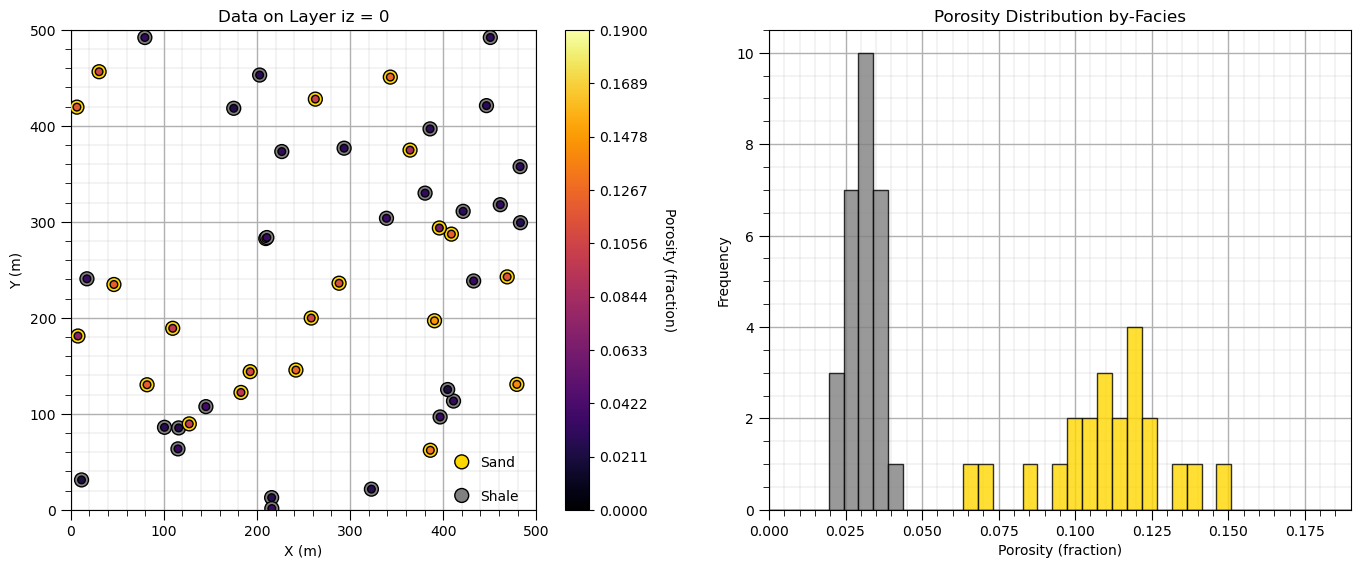

In [6]:
seed = 73073; nbin = 40                                       # set the random seed again to ensure repeatable data

random_data = True; ndata = 50                                # random data boolean and if random data, number of random data

if random_data == True:                                       # method for making random data
    np.random.seed(seed=seed)
    dx = np.random.uniform(low=xmin, high=xmax, size=ndata)
    dy = np.random.uniform(low=xmin, high=xmax, size=ndata)
    dz = np.full((ndata),0.5)
    por_sand = np.random.normal(loc=0.1, scale=0.025, size=ndata) # shale and sand values from respective distributions
    por_shale = np.random.normal(loc=0.03, scale=0.005, size=ndata) 
    facies = np.random.randint(0,2,size=ndata)                # shale (0) and sand (1)
    porosity = np.where(facies == 0, por_shale, por_sand)     # if shale take from shale distribution, otherwise the sand distribution
else:
    dx = np.array([5.001,55.01,75.01,95.01]); dy = np.array([5.0,55.0,75.0,15.0]); dz = np.array([0.5,0.5,0.5,0.5])
    porosity = np.array([0.06,0.09,0.12,0.15]);

df = pd.DataFrame({'X': dx,'Y':dy,'Z':dz,'Facies':facies,'Porosity':porosity})
df_shale = df[df['Facies'] == 0]; df_sand = df[df['Facies'] == 1]

pormin = 0.00; pormax = 0.19                                  # set feature min and max for colorbars
tmin = -99999.9; tmax = 99999.9

plt.subplot(121)                                              # plot the sythetic data
sc = plt.scatter(df['X'],df['Y'],c=df['Facies'],s=100,cmap=cmap_facies,edgecolor='black',vmin=0,vmax=1,zorder=10)
sc = plt.scatter(df['X'],df['Y'],c=df['Porosity'],s=30,cmap=cmap,edgecolor='black',vmin=pormin,vmax=pormax,zorder=10)
cbar = plt.colorbar(sc, orientation="vertical", ticks=np.linspace(pormin,pormax,10))
cbar.set_label('Porosity (fraction)', rotation=270, labelpad=20)
plt.scatter([420,420],[15,50],c=[0,1],s=100,edgecolor='black',cmap=cmap_facies)
plt.annotate('Sand',[440,45]); plt.annotate('Shale',[440,10])
plt.xlim(xmin,xmax); plt.ylim(ymin,ymax); add_grid(); plt.xlabel('X (m)'); plt.ylabel('Y (m)'); plt.title('Data on Layer iz = 0')

plt.subplot(122)
plt.hist(df_sand['Porosity'],color='gold',edgecolor='black',bins=np.linspace(pormin,pormax,nbin),alpha=0.8)
plt.hist(df_shale['Porosity'],color='grey',edgecolor='black',bins=np.linspace(pormin,pormax,nbin),alpha=0.8)
plt.xlim([pormin,pormax]); add_grid(); plt.xlabel('Porosity (fraction)'); plt.ylabel('Frequency'); plt.title('Porosity Distribution by-Facies')

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=1.0, wspace=0.2, hspace=0.2); plt.show()

#### SISIM 3D Demonstration 

Using the grid definition and synthetic data above, here we calculate realizations of sequential indicator simulation. Here's the current assumptions,

* **Two Facies** - sand (1) and shale (0)

* **Same Indicator Variogram** - for both sand and shale. You can experiment with this, but with 2 facies there is limited freedom as they constrain each other and contradictory (very different) variogram models will likely not be honored and lead to a lot of order relations issues. 

* **Random Data** - from above. Warning, too many random data will impose nugget effect spatial continuity in the realizations. Ironically, the best way to make data synthetic data consistent with a variogram model is to calculate an unconditional realization and to extract the data, i.e., you need a simulation to make data for a simulation! I wanted to keep this demonstration simple so I just made random data.

* **Singular Matrices** - data cannot be exactly at cell centroids as this could cause previously simulated nodes and data to be collocated and this will cause singular kriging matrices. A very small random offset will take care of this.

* **First Version** - I have not tested all the options, for example, locally variable mean (LVM), collocated cokriging options have not been checked.

Now here is the code to calculate an ensemble of simulated facies realizations.

* we run nreal realizations and visualize the layer iz = 0 layer of each to check the data conditioning

In [7]:
%%capture --no-display  

seed = 73071                                                  # realization seed
nreal = 3                                                     # number of realizations

ncut = 2                                                      # number of facies
thresh = [0,1]                                                # the facies categories (use consistent order for all lists)
gcdf = [0.5,0.5]                                              # the global proportions of the categories (shale, sand)
variomaj = 50.0; variomin = 50.0; variovert = 5.0
facies_varios = []                                            # the variogram list with shale and sand variograms (in order of thresh list)
facies_varios.append(geostats.make_variogram3D(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45,dip1=0,hmaj1=variomaj,hmin1=variomin,hvert1=variovert)) 
facies_varios.append(geostats.make_variogram3D(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45,dip1=0,hmaj1=variomaj,hmin1=variomin,hvert1=variovert)) 
    
ndmin = 0; ndmax = 3                                          # minimum and maximum data for indicator kriging
nodmax = 3                                                    # maximum previously simulated nodes for indicator kriging
nxdis = 1; nydis = 1                                          # block kriging discretizations
dummy_trend = np.zeros((nz,ny,nx,2))                           # current version requires trend - if wrong size = ignored 
tmin = -999; tmax = 999                                       # data trimming limits

run_model = True                                              # run the simulation model
nreal = 3                                                     # number of realizations

if run_model == True:
    sim_ik = geostats.sisim_3D(df,'X','Y','Z','Facies',ivtype=0,koption=0,ncut=2,thresh=thresh,gcdf=gcdf,trend=dummy_trend,
        tmin=tmin,tmax=tmax,zmin=0.0,zmax=1.0,ltail=1,ltpar=1,middle=1,mpar=0,utail=1,utpar=2,nreal=nreal,
        nx=grd3D['nx'],xmn=grd3D['xmn'],xsiz=grd3D['xsiz'],ny=grd3D['ny'],ymn=grd3D['ymn'],ysiz=grd3D['ysiz'],
        nz=grd3D['nz'],zmn=grd3D['zmn'],zsiz=grd3D['zsiz'],
        seed = seed,ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,ktype=0,varios=facies_varios)

nrow = int(round(((nreal+0.9)/3),0))                          # adjust plot for the number of realizations
for ireal in range(0,nreal):
    plt.subplot(nrow,3,ireal+1)                                  
    GSLIB.locpix_st(sim_ik[ireal][0],grd3D['xmin'],grd3D['xmax'],grd3D['ymin'],grd3D['ymax'],grd3D['xsiz'],0.0,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation Realization #' + str(ireal+1) + ' - iz = 0','X(m)','Y(m)','Facies',cmap_facies)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.0*nrow, wspace=0.2, hspace=0.2); plt.show()

AttributeError: module 'geostatspy.geostats' has no attribute 'sisim_3D'

Let's plot all the iz layers of the first realization.

* I select a long vertical variogram range relative to the model vertical extents (zmax - zmin) so we can see conspicuous spatial continuity between the layers.

NameError: name 'sim_ik' is not defined

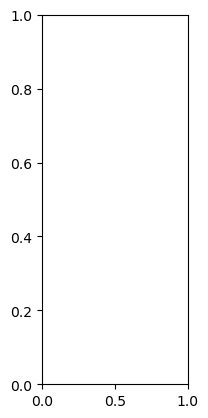

In [8]:
ireal = 0                                                     # select realization for display

nrow = int(round(((grd3D['nz']+0.9)/3),0))                    # adjust plot for the number of realizations
for iz in range(0,grd3D['nz']):
    plt.subplot(nrow,3,iz+1)   
    if iz == 0:
        GSLIB.locpix_st(sim_ik[ireal][iz],grd3D['xmin'],grd3D['xmax'],grd3D['ymin'],grd3D['ymax'],grd3D['xsiz'],0.0,1.0,df,'X','Y','Facies',
                'Sequential Indicator Simulation - Realization #' + str(ireal+1) + ' - iz = ' + str(iz+1),'X(m)','Y(m)','Facies',cmap_facies)
    else:
        GSLIB.pixelplt_st(sim_ik[ireal][iz],grd3D['xmin'],grd3D['xmax'],grd3D['ymin'],grd3D['ymax'],grd3D['xsiz'],0.0,1.0,
                         'Sequential Indicator Simulation - Realization #' + str(ireal+1) + ' - iz = ' + str(iz+1),'X(m)','Y(m)','Facies',cmap_facies)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.0*nrow, wspace=0.2, hspace=0.2); plt.show()

Now let's look at the center slices for a single realization of our 3D facies model,

* y and x - plan view

* z and x - vertical slice in x

* z and y - vertical slice in y

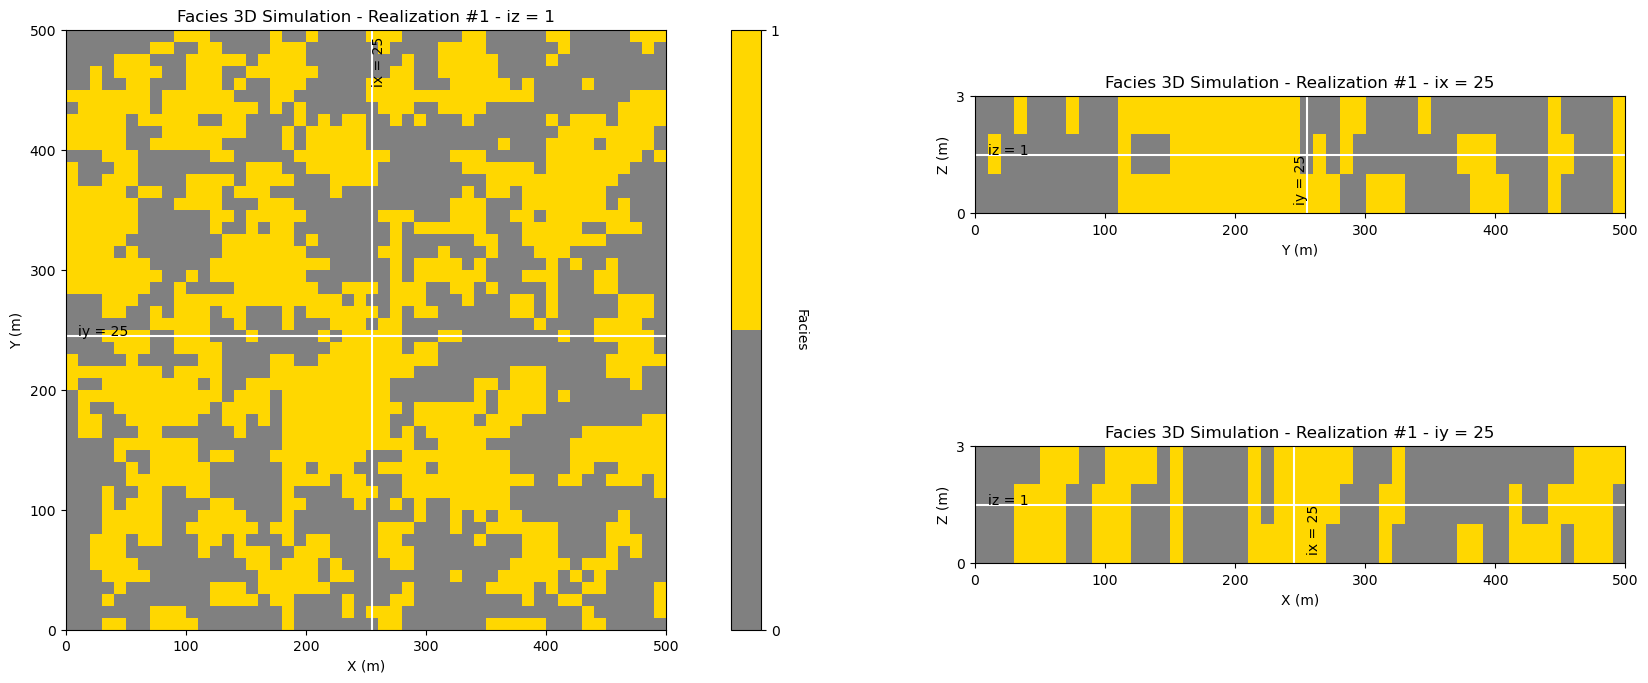

In [287]:
ireal = 0                                                     # select realization for display

plot_center_slices_3D(sim_ik[ireal],grd3D,'Facies 3D Simulation - Realization #' + str(ireal+1),'Facies', # plotting function
        vmin=0.0,vmax=1.0,nvbin=2,cmap=cmap_facies)

#### SGSIM 3D Demonstration

Now we can simulate porosity sand only and shale only realizations and then use the 'cookie cutter' method to put them together.

* **Same Variogram** - for both sand and shale. You can experiment with this. You have complete freedom to assign any variograms to both.

* **Random Data** - from above. Warning, too many random data will impose nugget effect spatial continuity in the realizations. Ironically, the best way to make data synthetic data consistent with a variogram model is to calculate an unconditional realization and to extract the data, i.e., you need a simulation to make data for a simulation! I wanted to keep this demonstration simple so I just made random data.

* **Singular Matrices** - data cannot be exactly at cell centroids as this could cause previously simulated nodes and data to be collocated and this will cause singular kriging matrices. A very small random offset will take care of this.

* **First Version** - I have not tested all the options, for example, locally variable mean (LVM), collocated cokriging options have not been checked.

Now here is the code to calculate an ensemble of simulated porosity realizations.

* **by-facies** - we simulate porosity for shale and sand separately and then used the "cookie-cutter" approach to combine with the associated facies realization, by selecting shale porosity at shale locations and sand porosity at sand locations

In [1]:
%%capture --no-display  

seed = 73077                                                  # realization seed
nreal = 1

variomaj = 70.0; variomin = 30.0; variovert = 1.0             # porosity variogram, assumed same for shale and sand facies
porosity_vario = geostats.make_variogram3D(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45,dip1=0,hmaj1=variomaj,hmin1=variomin,hvert1=variovert) 
    
ndmin = 0; ndmax = 4                                          # minimum and maximum data for indicator kriging
nodmax = 10                                                   # maximum previously simulated nodes for indicator kriging
nxdis = 1; nydis = 1                                          # block kriging discretizations
dummy_trend = np.zeros((nz,ny,nx,2))                          # current version requires trend - if wrong size = ignored 
tmin = -999; tmax = 999                                       # data trimming limits

run_model = True                                              # run the simulation model

if run_model == True:
    sim_por_sand = geostats.sgsim_3D(df_sand,'X','Y','Z','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=None,tcol='Ref',twtcol=-1,
        zmin=pormin,zmax=pormax,ltail=1,ltpar=pormin,utail=1,utpar=pormax,nreal=nreal,
        nx=grd3D['nx'],xmn=grd3D['xmn'],xsiz=grd3D['xsiz'],ny=grd3D['ny'],ymn=grd3D['ymn'],ysiz=grd3D['ysiz'],
        nz=grd3D['nz'],zmn=grd3D['zmn'],zsiz=grd3D['zsiz'],
        seed=seed,ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,
        ktype=0,colocorr=0,sec_map=0,vario=porosity_vario)
    sim_por_sand[0][sim_ik[0] == 0] = np.nan

    sim_por_shale = geostats.sgsim_3D(df_shale,'X','Y','Z','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=None,tcol='Ref',twtcol=-1,
        zmin=pormin,zmax=pormax,ltail=1,ltpar=pormin,utail=1,utpar=pormax,nreal=nreal,
        nx=grd3D['nx'],xmn=grd3D['xmn'],xsiz=grd3D['xsiz'],ny=grd3D['ny'],ymn=grd3D['ymn'],ysiz=grd3D['ysiz'],
        nz=grd3D['nz'],zmn=grd3D['zmn'],zsiz=grd3D['zsiz'],
        seed=seed,ndmin=ndmin,ndmax=ndmax,nodmax=nodmax,mults=1,nmult=3,noct=-1,
        ktype=0,colocorr=0,sec_map=0,vario=porosity_vario)
    sim_por_shale[0][sim_ik[0] == 1] = np.nan
    sim_por = np.where(~np.isnan(sim_por_shale), sim_por_shale, sim_por_sand)

nrow = int(round(((nreal+0.9)/3),0))                          # adjust plot for the number of realizations
for ireal in range(0,nreal):
    plt.subplot(nrow,3,ireal+1)                                  
    GSLIB.locpix_st(sim_por[ireal][0],grd3D['xmin'],grd3D['xmax'],grd3D['ymin'],grd3D['ymax'],grd3D['xsiz'],pormin,pormax,
        df_sand,'X','Y','Porosity',
        'Sequential Gaussian Simulation - Realization #' + str(ireal+1),'X(m)','Y(m)','Porosity',plt.cm.inferno)
    plt.scatter(df['X'],df['Y'],c=df['Porosity'],edgecolor='white',s=20,lw=1,cmap=plt.cm.inferno,vmin=pormin,vmax=pormax)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.0*nrow, wspace=0.2, hspace=0.2); plt.show()

NameError: name 'geostats' is not defined

Let's plot all the iz layers of the first realization.

* I select a long vertical variogram range relative to the model vertical extents (zmax - zmin) so we can see conspicuous spatial continuity between the layers.

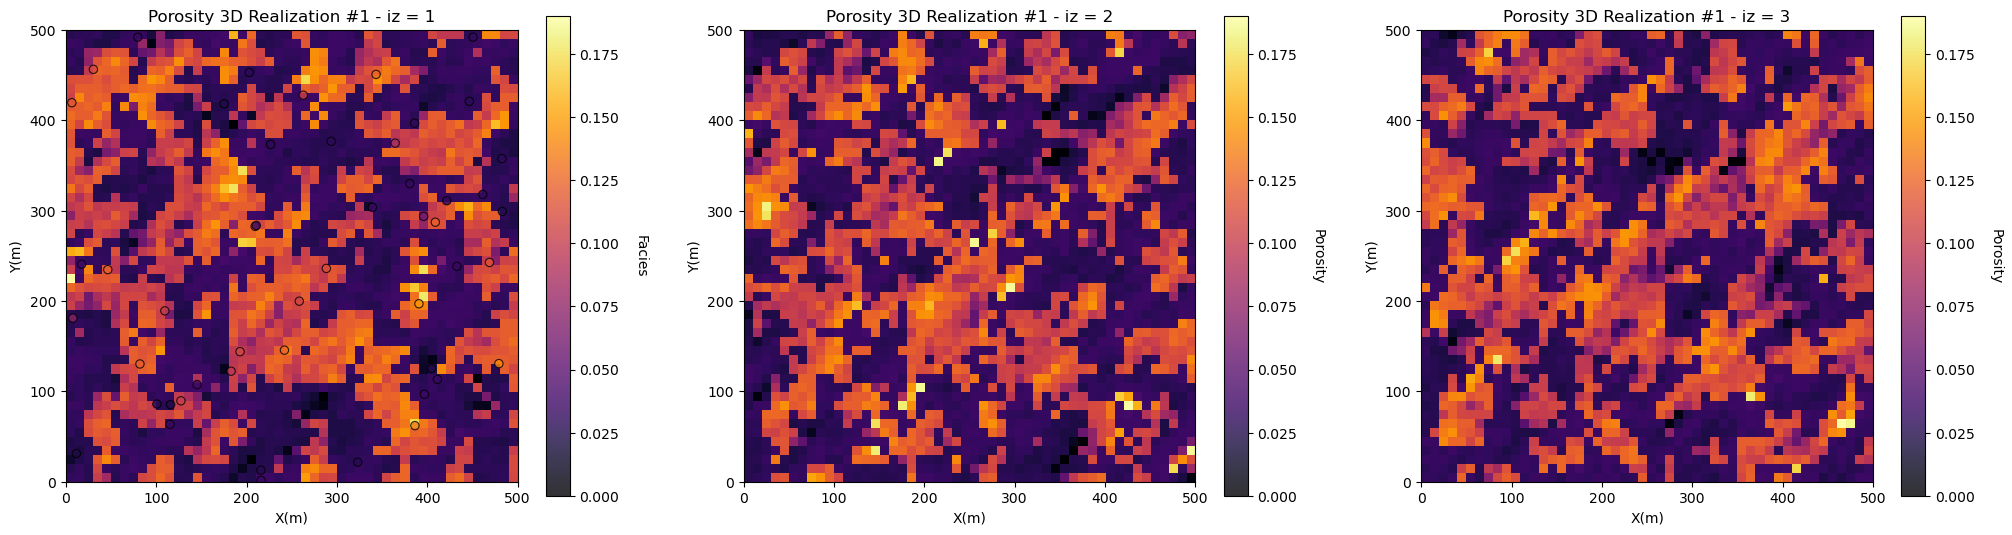

In [291]:
ireal = 0                                                     # select realization for display

nrow = int(round(((grd3D['nz']+0.9)/3),0))                    # adjust plot for the number of realizations
for iz in range(0,grd3D['nz']):
    plt.subplot(nrow,3,iz+1)   
    if iz == 0:
        GSLIB.locpix_st(sim_por[ireal][iz],grd3D['xmin'],grd3D['xmax'],grd3D['ymin'],grd3D['ymax'],grd3D['xsiz'],pormin,pormax,df,'X','Y','Porosity',
                'Porosity 3D Realization #' + str(ireal+1) + ' - iz = ' + str(iz+1),'X(m)','Y(m)','Facies',cmap)
    else:
        GSLIB.pixelplt_st(sim_por[ireal][iz],grd3D['xmin'],grd3D['xmax'],grd3D['ymin'],grd3D['ymax'],grd3D['xsiz'],pormin,pormax,
                         'Porosity 3D Realization #' + str(ireal+1) + ' - iz = ' + str(iz+1),'X(m)','Y(m)','Porosity',cmap)

plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.0*nrow, wspace=0.2, hspace=0.2); plt.show()

Now let's look at the center slices for a single porosity realization,

* y and x - plan view

* z and x - vertical slice in x

* z and y - vertical slice in y

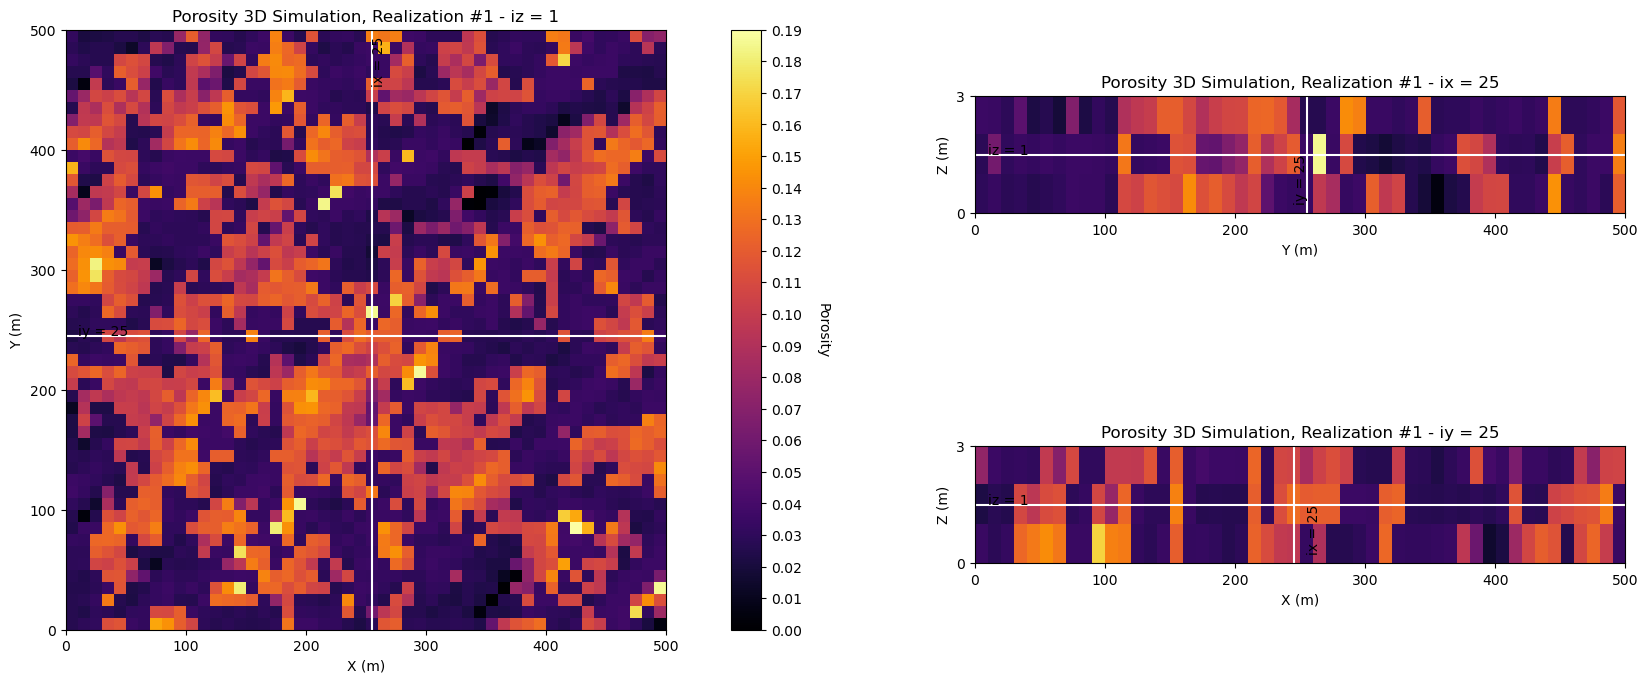

In [305]:
ireal = 0                                                     # select realization for display

plot_center_slices_3D(sim_por[ireal],grd3D,'Porosity 3D Simulation, Realization #' + str(ireal+1),'Porosity', # plotting function
        vmin=pormin,vmax=pormax,nvbin=20,cmap=cmap)

#### Comments

I hope you found this demonstration of 3D simulation chapter helpful. Much more could be done and discussed, I have many more resources. Check out my [shared resource inventory](https://michaelpyrcz.com/my-resources),

*Michael*

#### About the Author

<figure style="text-align: center;">
  <img src="_static/intro/michael_pyrcz_officeshot_jacket.jpg" style="display: block; margin: 0 auto; width: 70%;">
  <figcaption style="text-align: center;"> Professor Michael Pyrcz in his office on the 40 acres, campus of The University of Texas at Austin.
</figcaption>
</figure>

Michael Pyrcz is a professor in the [Cockrell School of Engineering](https://cockrell.utexas.edu/faculty-directory/alphabetical/p), and the [Jackson School of Geosciences](https://www.jsg.utexas.edu/researcher/michael_pyrcz/), at [The University of Texas at Austin](https://www.utexas.edu/), where he researches and teaches subsurface, spatial data analytics, geostatistics, and machine learning. Michael is also,

* the principal investigator of the [Energy Analytics](https://fri.cns.utexas.edu/energy-analytics) freshmen research initiative and a core faculty in the Machine Learn Laboratory in the College of Natural Sciences, The University of Texas at Austin

* an associate editor for [Computers and Geosciences](https://www.sciencedirect.com/journal/computers-and-geosciences/about/editorial-board), and a board member for [Mathematical Geosciences](https://link.springer.com/journal/11004/editorial-board), the International Association for Mathematical Geosciences. 

Michael has written over 70 [peer-reviewed publications](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en), a [Python package](https://pypi.org/project/geostatspy/) for spatial data analytics, co-authored a textbook on spatial data analytics, [Geostatistical Reservoir Modeling](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) and author of two recently released e-books, [Applied Geostatistics in Python: a Hands-on Guide with GeostatsPy](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) and [Applied Machine Learning in Python: a Hands-on Guide with Code](https://geostatsguy.github.io/MachineLearningDemos_Book/intro.html).

All of Michael’s university lectures are available on his [YouTube Channel](https://www.youtube.com/@GeostatsGuyLectures) with links to 100s of Python interactive dashboards and well-documented workflows in over 40 repositories on his [GitHub account](https://github.com/GeostatsGuy), to support any interested students and working professionals with evergreen content. To find out more about Michael’s work and shared educational resources visit his [Website](www.michaelpyrcz.com).

#### Want to Work Together?

I hope this content is helpful to those that want to learn more about subsurface modeling, data analytics and machine learning. Students and working professionals are welcome to participate.

* Want to invite me to visit your company for training, mentoring, project review, workflow design and / or consulting? I'd be happy to drop by and work with you! 

* Interested in partnering, supporting my graduate student research or my Subsurface Data Analytics and Machine Learning consortium (co-PI is Professor John Foster)? My research combines data analytics, stochastic modeling and machine learning theory with practice to develop novel methods and workflows to add value. We are solving challenging subsurface problems!

* I can be reached at mpyrcz@austin.utexas.edu.

I'm always happy to discuss,

*Michael*

Michael Pyrcz, Ph.D., P.Eng. Professor, Cockrell School of Engineering and The Jackson School of Geosciences, The University of Texas at Austin

More Resources Available at: [Twitter](https://twitter.com/geostatsguy) | [GitHub](https://github.com/GeostatsGuy) | [Website](http://michaelpyrcz.com) | [GoogleScholar](https://scholar.google.com/citations?user=QVZ20eQAAAAJ&hl=en&oi=ao) | [Geostatistics Book](https://www.amazon.com/Geostatistical-Reservoir-Modeling-Michael-Pyrcz/dp/0199731446) | [YouTube](https://www.youtube.com/channel/UCLqEr-xV-ceHdXXXrTId5ig)  | [Applied Geostats in Python e-book](https://geostatsguy.github.io/GeostatsPyDemos_Book/intro.html) | [Applied Machine Learning in Python e-book](https://geostatsguy.github.io/MachineLearningDemos_Book/) | [LinkedIn](https://www.linkedin.com/in/michael-pyrcz-61a648a1)  